<a href="https://www.kaggle.com/code/jy2040/task2-nlp?scriptVersionId=94539476" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# libraries used for this task
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from nltk.corpus import stopwords
import string
import collections
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from keras.utils.vis_utils import plot_model

In [2]:
'''
1. Load the movie reviews sentiment analysis dataset and split into 80:20 ratio for training and test data (2 points)
'''
data = pd.read_csv('../input/cifar10/Sentiment Analysis Dataset.csv')
data['sentiment'] = data['sentiment'].replace(['positive','negative'],[0,1])
# X_train, X_test, y_train, y_test = train_test_split(data.review, data.sentiment, test_size=0.20, random_state=42)

In [3]:
'''
2. Lexical vs Semantic Text analysis

Lexical Text Analysis: Lexical analysis is reffered as the process of extracting an individual words or lexemes from an
input stream of symbols and passing corresponding tokens back to the parser
The process starts defining a token in terms of language with a regular expression then it translates to the abstract 
computational model for recognising tokens. Which the further translated to an implementation for recognising the 
earlier defined tokens to which optimisation can be made.

Semantic Text Analysis:  Semantic analysis, to put it simply, is the process of extracting meaning from text.
It enables computers to comprehend and interpret sentences, paragraphs, or entire documents by evaluating their
grammatical structure and recognizing relationships between individual words in a given context.
Lexical semantics is crucial to semantic analysis because it allows machines to grasp relationships between lexical
objects (words, phrasal verbs, and so on)
'''


'\n2. Lexical vs Semantic Text analysis\n\nLexical Text Analysis: Lexical analysis is reffered as the process of extracting an individual words or lexemes from an\ninput stream of symbols and passing corresponding tokens back to the parser\nThe process starts defining a token in terms of language with a regular expression then it translates to the abstract \ncomputational model for recognising tokens. Which the further translated to an implementation for recognising the \nearlier defined tokens to which optimisation can be made.\n\nSemantic Text Analysis:  Semantic analysis, to put it simply, is the process of extracting meaning from text.\nIt enables computers to comprehend and interpret sentences, paragraphs, or entire documents by evaluating their\ngrammatical structure and recognizing relationships between individual words in a given context.\nLexical semantics is crucial to semantic analysis because it allows machines to grasp relationships between lexical\nobjects (words, phrasal

In [4]:
%%time
'''
3. Perform required preprocessing on the dataset (removing stop words, vectorization etc.) (10 points)
'''
# functions to clean the data and make a vocabulary file
# creating a vocabulary file to clean the data for following steps...
def clean_review(text):
    # split into tokens by white space
    text = text.lower()
    tokens = text.split()
    
    # remove punctuation from each token
    mapping_table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(mapping_table) for w in tokens]
    
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    
    # removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    
    # removing tokens with 1 length
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

# building a vocabulary out of all text documents
def create_vocab(data_review):
    vocabulary = collections.Counter()
    for doc in data_review:
        tokens = clean_review(doc)
        vocabulary.update(tokens)
    return vocabulary

vocab_dict = create_vocab(data.review)

# removing vocabulary which occures very less
min_occurrence = 2  #define your own occurrence count
tokens = [k for k,c in vocab_dict.items() if c >= min_occurrence]

CPU times: user 21.5 s, sys: 1.05 s, total: 22.6 s
Wall time: 22.6 s


In [5]:
def save_list(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
    
# creating text file for vocabulary
save_list(tokens, 'vocab.txt')

In [6]:
# load doc into memory
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

vocab_filename = './vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

In [7]:
print("Total size of vocabulary from the reviews is",len(vocab),"words")

Total size of vocabulary from the reviews is 79750 words


In [8]:
# using vocabulary that we created in previous steps
def process_text(text, vocab):
    
    # split into tokens by white space
    tokens = text.split()
    
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # filter out tokens not in vocab
    
    tokens = [w for w in tokens if w in vocab]
    tokens = ' '.join(tokens)
    return tokens

def process_reviews(data_review, vocab):
    documents = list()
    for doc in data_review:
        tokens = process_text(doc, vocab)
        # add to list
        documents.append(tokens)
    return documents

In [9]:
%%time
processed_data = process_reviews(data.review, vocab)

CPU times: user 9.15 s, sys: 88.9 ms, total: 9.24 s
Wall time: 9.24 s


In [10]:
# text review after processing + cleaning it
processed_data[0]

'reviewers mentioned watching episode youll hooked right exactly happened mebr br first thing struck brutality unflinching scenes violence set right word show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordbr br called nickname given focuses mainly experimental section prison cells glass fronts face inwards privacy high agenda home gangstas moreso scuffles death stares dodgy dealings shady agreements never far awaybr br would say main appeal show due fact goes shows wouldnt dare pretty pictures painted mainstream audiences forget charm forget doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannered middle class inmates turned prison bitches due lack street skills prison experience may become comfortable uncomfortable get touch darker side'

In [11]:
# creating the tokenizer 
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(processed_data)

In [12]:
# encoding the data
tokenized_data = tokenizer.texts_to_sequences(processed_data)

In [13]:
# padding the data
max_length = max([len(s.split()) for s in processed_data])
X = tf.keras.preprocessing.sequence.pad_sequences(tokenized_data, maxlen=max_length, padding='post')
y = np.array(data.sentiment)

In [14]:
'''
Splitting the data into 80:20 ratio
'''
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.2)

In [15]:
%%time
'''
4. Build a model to classify the rows (5 points).
'''
rc = RandomForestClassifier()
rc.fit(X_train,y_train)

CPU times: user 34.3 s, sys: 166 ms, total: 34.5 s
Wall time: 34.5 s


RandomForestClassifier()

In [16]:
predictions = rc.predict(X_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test,predictions))

0.5423
[[2849 2190]
 [2387 2574]]


In [17]:
# define model
# defining vocabulary size
vocab_size = len(tokenizer.word_index) + 1
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 100, input_length=max_length))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=4, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 998, 100)          5642100   
_________________________________________________________________
conv1d (Conv1D)              (None, 991, 32)           25632     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 988, 32)           4128      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 494, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 15808)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                158090    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

2022-05-02 05:30:52.045564: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [18]:
# compiling the neural network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

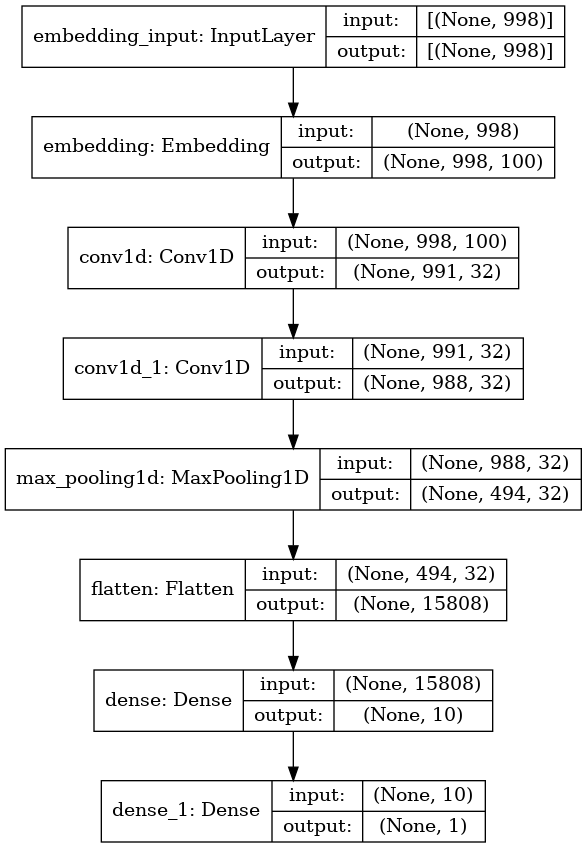

In [19]:
plot_model(model, to_file='final_model.png', show_shapes=True, show_layer_names=True)

In [20]:
%%time
model.fit(X_train, y_train, epochs=5, validation_data= (X_test,y_test))

2022-05-02 05:30:53.442074: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
1250/1250 [==============================] - 148s 118ms/step - loss: 0.4574 - accuracy: 0.8289 - val_loss: 0.3537 - val_accuracy: 0.8841
Epoch 2/5
1250/1250 [==============================] - 145s 116ms/step - loss: 0.2493 - accuracy: 0.9272 - val_loss: 0.3194 - val_accuracy: 0.8795
Epoch 3/5
1250/1250 [==============================] - 144s 115ms/step - loss: 0.1356 - accuracy: 0.9592 - val_loss: 0.3662 - val_accuracy: 0.8793
Epoch 4/5
1250/1250 [==============================] - 143s 114ms/step - loss: 0.0801 - accuracy: 0.9762 - val_loss: 0.5324 - val_accuracy: 0.8753
Epoch 5/5
1250/1250 [==============================] - 145s 116ms/step - loss: 0.0460 - accuracy: 0.9859 - val_loss: 0.5993 - val_accuracy: 0.8726
CPU times: user 37min 19s, sys: 25 s, total: 37min 44s
Wall time: 12min 4s


In [21]:
# evaluate the model
model.evaluate(X_test,y_test)

313/313 [==============================] - 6s 20ms/step - loss: 0.5993 - accuracy: 0.8726


[0.5993252396583557, 0.8726000189781189]